# SVR

In [1]:
%matplotlib inline
from bs4 import BeautifulSoup
# import urllib2
from urllib.request import urlopen
import urllib
import json
import csv
import time
import pickle
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
# import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
import sys
import os
import time
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.svm import SVR
# import pandas as pd
# import numpy as np
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols
from sklearn import model_selection, datasets, svm

In [2]:
all_features = pd.read_csv('all_features.csv')

In [3]:
# drop the 2 unnamed columns and Avg_Tweets (this column is buggy & I already computed it)
all_features.drop(['Unnamed: 0','Unnamed: 0.1','Avg_Tweets'], axis=1, inplace=True)


In [4]:
all_features.head()

,company_name,Series,Total_Likes,Total_Retweets,Series_Amount,Market,tweet_count,get_dayrange,get_dayiqr,likes_mean,retweets_mean,persontag_count_mean,hashtag_count_mean,text_length_mean,persontags_count_mean,hashtags_count_mean,links_count_mean,self_mention_mean,self_tweet_mean,likes_std,retweets_std,persontag_count_std,hashtag_count_std,text_length_std,persontags_count_std,hashtags_count_std,links_count_std,self_mention_std,self_tweet_std,is_Biotechnology,is_Software,is_Health Care,is_Enterprise Software,is_Clean Technology,is_Hardware + Software,is_Semiconductors,is_Curated Web,is_Mobile,is_Web Hosting,is_Series_A,is_Series_B,is_Series_C,is_Series_D,mean_neg,mean_pos,total_neg,total_pos
0,1stdibs,_Series_C,230,134,15000000,Semiconductors,213,13,7,1.863850,1.521127,0.957746,1.098592,130.516432,0.934272,1.093897,0.840376,0.436620,0.145540,5.780192,7.009816,1.087276,1.882052,38.451464,1.079570,1.876018,0.458529,0.515763,0.353475,False,False,False,False,False,False,True,False,False,False,False,False,True,False,0.038290,0.068850,0.010989,0.082418
1,2tor,_Series_C,10,32,32500000,NaN,162,98,42,0.061728,0.197531,0.956790,0.574074,108.623457,0.864198,0.574074,0.697531,0.185185,0.000000,0.328584,0.648357,1.287053,0.648031,34.011510,1.268374,0.648031,0.486967,0.389652,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0.018364,0.042564,0.000000,0.060606
2,365Scores,_Series_B,15,23,5500000,Apps,163,1,1,0.092025,0.141104,0.582822,1.515337,181.895705,0.552147,1.490798,0.914110,0.184049,0.049080,0.348007,0.656189,0.822642,1.113086,43.445668,0.771029,1.090747,0.302230,0.388718,0.216700,False,False,False,False,False,False,False,False,False,False,False,True,False,False,0.019701,0.046836,0.006329,0.006329
3,36Kr,_Series_C,58,21,20000,Startups,173,83,43,1.312139,0.393064,0.364162,0.520231,149.664740,0.289017,0.427746,0.630058,0.023121,0.000000,12.936146,2.761100,0.792618,1.009200,85.569792,0.680070,0.896851,0.518964,0.150725,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0.036364,0.058589,0.051546,0.077320
4,6fusion,_Series_B,2,28,7000000,Hardware + Software,177,251,131,0.011299,0.158192,0.593220,0.468927,108.621469,0.564972,0.463277,0.576271,0.384181,0.050847,0.105996,0.462028,0.894147,0.783636,32.634132,0.896657,0.776104,0.539467,0.487781,0.220309,False,False,False,False,False,True,False,False,False,False,False,True,False,False,0.021415,0.037837,0.000000,0.000000


In [5]:
INDICES = ['company_name', 'Series']
# numerical columns
NUMCOLS = [col for col in all_features.columns if not col in ['company_name', 'Series','Market']]
ISCOLS = [col for col in all_features.columns if col.startswith('is_')]
NUMCOLS_NOFUNDING = [col for col in NUMCOLS if col != 'Series_Amount']

In [6]:
#NUMCOLS_SCALED = [col for col in all_features_pca.columns if col.endswith('_scaled')]
NUMCOLS_SCALED = [col + '_scaled' for col in NUMCOLS]
NUMCOLS_NOFUNDING_SCALED = [col + '_scaled' for col in NUMCOLS_NOFUNDING]

In [7]:
all_features.dropna().to_csv('all_features_dropna.csv')

In [8]:
all_features_pca = all_features.copy()

In [9]:
from scipy.stats import boxcox
# standardize all the numerical columns, including the boolean ones
for col in NUMCOLS_NOFUNDING:
    # all_features[col + '_scaled'] = (all_features[col] - np.mean(all_features[col]))/np.std(all_features[col])
    all_features_pca[col + '_scaled'] = boxcox(all_features_pca[col]+1)[0]

In [10]:
all_features_pca['Series_Amount_scaled'] = np.log(all_features_pca['Series_Amount'])

In [11]:
# left-join leaves some sentiment features hanging, remove null
all_features_pca.dropna(inplace=True)

In [12]:
all_features_pca[NUMCOLS_SCALED].head()

,Total_Likes_scaled,Total_Retweets_scaled,Series_Amount_scaled,tweet_count_scaled,get_dayrange_scaled,get_dayiqr_scaled,likes_mean_scaled,retweets_mean_scaled,persontag_count_mean_scaled,hashtag_count_mean_scaled,text_length_mean_scaled,persontags_count_mean_scaled,hashtags_count_mean_scaled,links_count_mean_scaled,self_mention_mean_scaled,self_tweet_mean_scaled,likes_std_scaled,retweets_std_scaled,persontag_count_std_scaled,hashtag_count_std_scaled,text_length_std_scaled,persontags_count_std_scaled,hashtags_count_std_scaled,links_count_std_scaled,self_mention_std_scaled,self_tweet_std_scaled,is_Biotechnology_scaled,is_Software_scaled,is_Health Care_scaled,is_Enterprise Software_scaled,is_Clean Technology_scaled,is_Hardware + Software_scaled,is_Semiconductors_scaled,is_Curated Web_scaled,is_Mobile_scaled,is_Web Hosting_scaled,is_Series_A_scaled,is_Series_B_scaled,is_Series_C_scaled,is_Series_D_scaled,mean_neg_scaled,mean_pos_scaled,total_neg_scaled,total_pos_scaled
0,5.622138,14.802947,16.523561,11.993232,2.875401,2.135957,0.282394,0.446515,0.531914,0.460830,52.584573,0.513304,0.453416,0.790765,0.139256,0.078557,0.624168,0.979570,0.590415,1.183063,1.555538,0.583386,1.212561,1.512939,0.443300,0.259073,0.0,0.0,0.0,0.0,0.0,0.00000,0.009166,0.0,0.0,0.0,0.000000,0.000000,0.166457,0.0,0.044244,0.089455,0.011451,0.112856
2,2.818737,6.291091,15.520259,10.910415,0.708776,0.699352,0.075931,0.117297,0.390642,0.517367,67.966020,0.370990,0.505952,0.856485,0.102543,0.038952,0.240249,0.410775,0.500926,0.809020,1.570202,0.477926,0.811516,0.667859,0.345296,0.177163,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.432834,0.000000,0.0,0.021215,0.055915,0.006481,0.006481
3,4.177870,5.995654,9.903488,11.144621,5.124045,3.974139,0.273975,0.248706,0.278090,0.316733,58.460482,0.229885,0.278119,0.600570,0.021241,0.000000,0.648369,0.797131,0.489434,0.750492,1.636366,0.440849,0.695476,1.992113,0.143425,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.166457,0.0,0.041712,0.073172,0.062659,0.103803
4,1.105810,6.969322,15.761421,11.235547,6.636096,5.202095,0.011021,0.128821,0.395326,0.297191,45.607656,0.376771,0.292526,0.551227,0.135263,0.040039,0.093441,0.324910,0.527099,0.614636,1.534311,0.524269,0.618672,2.178751,0.422220,0.179567,0.0,0.0,0.0,0.0,0.0,0.00802,0.000000,0.0,0.0,0.0,0.000000,0.432834,0.000000,0.0,0.023210,0.043646,0.000000,0.000000
5,3.846461,8.652354,16.300417,12.032499,4.393806,3.355638,0.133276,0.178912,0.418528,0.308339,44.257807,0.390131,0.287711,0.178585,0.072176,0.000000,0.321821,0.542599,0.485609,0.838829,1.624679,0.468916,0.797237,1.060402,0.276237,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.207166,0.000000,0.000000,0.0,0.037100,0.092223,0.017234,0.175472


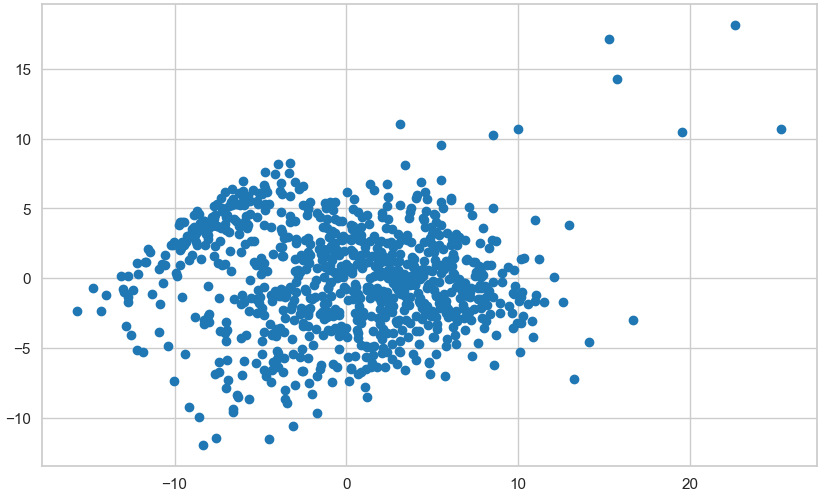

In [13]:
from sklearn.decomposition import PCA
pca = PCA()
temp = pca.fit_transform(all_features_pca[NUMCOLS_SCALED])
plt.figure(figsize=(20, 12), dpi=50)
plt.scatter([point[0] for point in temp],[point[1] for point in temp])

In [14]:
all_features_pca[NUMCOLS_SCALED].head()

,Total_Likes_scaled,Total_Retweets_scaled,Series_Amount_scaled,tweet_count_scaled,get_dayrange_scaled,get_dayiqr_scaled,likes_mean_scaled,retweets_mean_scaled,persontag_count_mean_scaled,hashtag_count_mean_scaled,text_length_mean_scaled,persontags_count_mean_scaled,hashtags_count_mean_scaled,links_count_mean_scaled,self_mention_mean_scaled,self_tweet_mean_scaled,likes_std_scaled,retweets_std_scaled,persontag_count_std_scaled,hashtag_count_std_scaled,text_length_std_scaled,persontags_count_std_scaled,hashtags_count_std_scaled,links_count_std_scaled,self_mention_std_scaled,self_tweet_std_scaled,is_Biotechnology_scaled,is_Software_scaled,is_Health Care_scaled,is_Enterprise Software_scaled,is_Clean Technology_scaled,is_Hardware + Software_scaled,is_Semiconductors_scaled,is_Curated Web_scaled,is_Mobile_scaled,is_Web Hosting_scaled,is_Series_A_scaled,is_Series_B_scaled,is_Series_C_scaled,is_Series_D_scaled,mean_neg_scaled,mean_pos_scaled,total_neg_scaled,total_pos_scaled
0,5.622138,14.802947,16.523561,11.993232,2.875401,2.135957,0.282394,0.446515,0.531914,0.460830,52.584573,0.513304,0.453416,0.790765,0.139256,0.078557,0.624168,0.979570,0.590415,1.183063,1.555538,0.583386,1.212561,1.512939,0.443300,0.259073,0.0,0.0,0.0,0.0,0.0,0.00000,0.009166,0.0,0.0,0.0,0.000000,0.000000,0.166457,0.0,0.044244,0.089455,0.011451,0.112856
2,2.818737,6.291091,15.520259,10.910415,0.708776,0.699352,0.075931,0.117297,0.390642,0.517367,67.966020,0.370990,0.505952,0.856485,0.102543,0.038952,0.240249,0.410775,0.500926,0.809020,1.570202,0.477926,0.811516,0.667859,0.345296,0.177163,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.432834,0.000000,0.0,0.021215,0.055915,0.006481,0.006481
3,4.177870,5.995654,9.903488,11.144621,5.124045,3.974139,0.273975,0.248706,0.278090,0.316733,58.460482,0.229885,0.278119,0.600570,0.021241,0.000000,0.648369,0.797131,0.489434,0.750492,1.636366,0.440849,0.695476,1.992113,0.143425,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.166457,0.0,0.041712,0.073172,0.062659,0.103803
4,1.105810,6.969322,15.761421,11.235547,6.636096,5.202095,0.011021,0.128821,0.395326,0.297191,45.607656,0.376771,0.292526,0.551227,0.135263,0.040039,0.093441,0.324910,0.527099,0.614636,1.534311,0.524269,0.618672,2.178751,0.422220,0.179567,0.0,0.0,0.0,0.0,0.0,0.00802,0.000000,0.0,0.0,0.0,0.000000,0.432834,0.000000,0.0,0.023210,0.043646,0.000000,0.000000
5,3.846461,8.652354,16.300417,12.032499,4.393806,3.355638,0.133276,0.178912,0.418528,0.308339,44.257807,0.390131,0.287711,0.178585,0.072176,0.000000,0.321821,0.542599,0.485609,0.838829,1.624679,0.468916,0.797237,1.060402,0.276237,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.207166,0.000000,0.000000,0.0,0.037100,0.092223,0.017234,0.175472


In [15]:
pca.components_[0]

array([ 1.37703355e-01,  6.45973205e-01,  1.93391796e-02, -1.61496681e-02,
       -1.10052327e-02, -7.03639721e-03,  8.70781927e-03,  1.69013579e-02,
        1.38357222e-02,  1.42914428e-02,  7.47060828e-01,  1.33523910e-02,
        1.38921206e-02,  2.08402040e-02,  3.28567639e-03,  2.19189185e-03,
        1.46268765e-02,  3.05537003e-02,  1.10147903e-02,  2.37966653e-02,
        6.98417994e-04,  1.11196709e-02,  2.45003965e-02,  2.30798273e-02,
        9.88336910e-03,  7.21961756e-03, -4.06839032e-06, -3.88640094e-06,
       -7.41560680e-06,  9.55611514e-06,  5.30716942e-07,  1.05958190e-05,
        9.46181028e-06,  3.33827335e-07, -1.87722509e-07,  3.36163419e-06,
       -1.30656229e-03,  1.80664087e-03,  1.14828525e-04,  8.76334758e-05,
       -3.72233661e-04, -1.85806787e-04, -5.03792968e-04, -5.03483348e-03])

In [16]:
pca.components_[1]

array([-1.57238910e-01, -6.84679912e-01, -4.43464294e-02, -2.76543350e-02,
        2.58727857e-01,  1.93646745e-01, -1.03908502e-02, -1.81477323e-02,
       -5.98765147e-03, -4.18866286e-03,  6.29650970e-01, -4.70368487e-03,
       -4.13817142e-03,  2.07642886e-02,  2.21960585e-04,  7.44471743e-04,
       -1.73119519e-02, -3.48640458e-02, -5.62885002e-03, -9.28744094e-03,
       -1.21122788e-03, -5.19737625e-03, -9.49407677e-03,  1.14605635e-02,
        1.24308325e-03,  2.56923663e-03,  5.71765273e-06, -6.69870306e-06,
       -3.99060724e-06, -1.21607637e-06,  2.00061382e-07, -4.75199643e-06,
       -3.80682185e-06,  7.48432267e-06, -8.26039823e-08, -6.93438961e-07,
       -7.17368534e-04,  7.08652742e-04,  8.26094665e-05,  8.07243500e-05,
       -4.37824997e-04, -1.77825158e-04, -7.08352877e-04,  1.93407502e-03])

In [17]:
# Save the resulting file to CSV
all_features_pca.to_csv('all_features_pca.csv')

Text(0.5, 1.0, 'PCA explains variance')

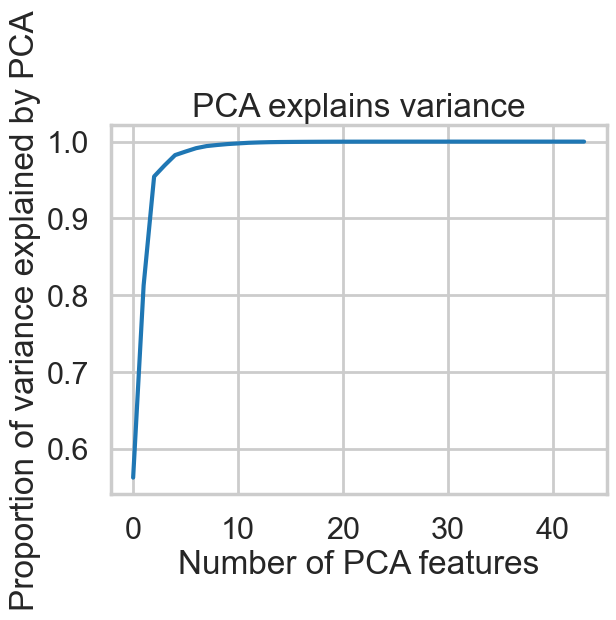

In [18]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of PCA features')
plt.ylabel('Proportion of variance explained by PCA')
plt.title('PCA explains variance')

In [19]:
itrain, itest = train_test_split(range(all_features.shape[0]), train_size=0.9)
mask=np.ones(all_features.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask=(mask==1)
df_train = all_features[mask]
df_test = all_features[~mask]

C:\Users\MY PC\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


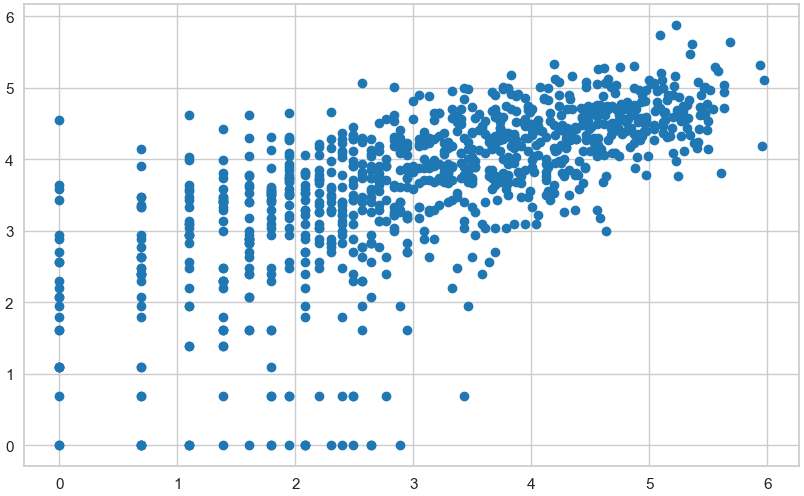

In [20]:
plt.figure(figsize=(20, 12), dpi=50)
plt.scatter(np.log(df_train['Total_Likes']), np.log(df_train['Total_Retweets']))
plt.savefig('pic.png', dpi=10)

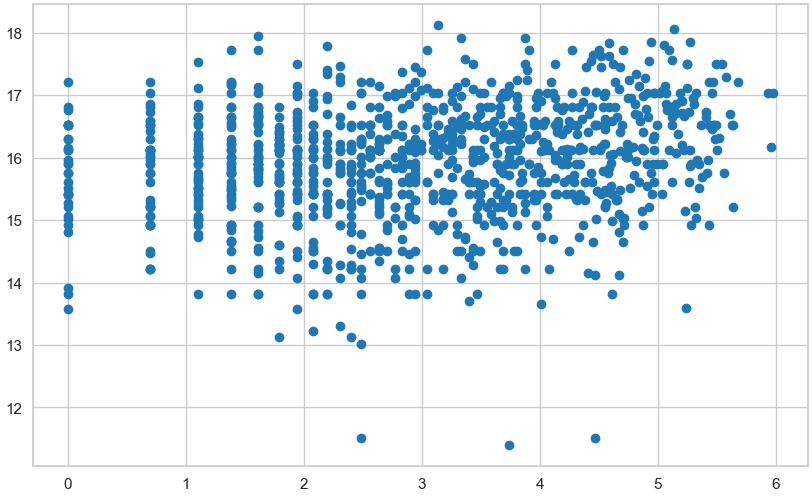

In [21]:
plt.figure(figsize=(20, 12), dpi=50)
plt.scatter(np.log(df_train['Total_Likes']), np.log(df_train['Series_Amount']))
plt.savefig('pic.png', dpi=10)

In [22]:
def get_rmse(s, s_predict):
    s, s_predict = pd.Series(s), pd.Series(s_predict)
    s, s_predict = np.array(s), np.array(s_predict)
    diff = s - s_predict
#     print(diff)
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [23]:
from sklearn import model_selection, datasets, svm

In [24]:
# standardize the training set and the testing set separately
for df in [df_train, df_test]:
    for col in NUMCOLS_NOFUNDING:
#         print("nee line")
#         print((df[col]+1))
#         print(boxcox(df[col]+1)[0])# standardize the data# standardize the data
        # all_features[col + '_scaled'] = (all_features[col] - np.mean(all_features[col]))/np.std(all_features[col])
        try:
            df[col + '_scaled'] = boxcox(df[col]+1)[0]
        except:
            pass
    df['Series_Amount_scaled'] = np.log(df['Series_Amount'])

C:\Users\MY PC\AppData\Local\Temp\ipykernel_6492\983511039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_scaled'] = boxcox(df[col]+1)[0]
C:\Users\MY PC\AppData\Local\Temp\ipykernel_6492\983511039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_scaled'] = boxcox(df[col]+1)[0]
C:\Users\MY PC\AppData\Local\Temp\ipykernel_6492\983511039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

C:\Users\MY PC\AppData\Local\Temp\ipykernel_6492\983511039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_scaled'] = boxcox(df[col]+1)[0]
C:\Users\MY PC\AppData\Local\Temp\ipykernel_6492\983511039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_scaled'] = boxcox(df[col]+1)[0]
C:\Users\MY PC\AppData\Local\Temp\ipykernel_6492\983511039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

C:\Users\MY PC\AppData\Local\Temp\ipykernel_6492\983511039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_scaled'] = boxcox(df[col]+1)[0]
C:\Users\MY PC\AppData\Local\Temp\ipykernel_6492\983511039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_scaled'] = boxcox(df[col]+1)[0]
C:\Users\MY PC\AppData\Local\Temp\ipykernel_6492\983511039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

C:\Users\MY PC\AppData\Local\Temp\ipykernel_6492\983511039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_scaled'] = boxcox(df[col]+1)[0]
C:\Users\MY PC\AppData\Local\Temp\ipykernel_6492\983511039.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Series_Amount_scaled'] = np.log(df['Series_Amount'])


In [25]:
df_train.to_csv('df_train.csv')
df_test.to_csv('df_test.csv')

In [26]:
svr_rbf = SVR(kernel='rbf')
svr_lin = SVR(kernel='linear')
svr_poly = SVR(kernel='poly')


In [27]:
# parameter grids
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.01, 0.1, 1, 10, 100]
degrees = [1, 2, 3, 4]

In [28]:
# X_train = df_train[NUMCOLS_SCALED_NOFUNDING]
# X_test = df_test[NUMCOLS_SCALED_NOFUNDING]
X_train = df_train['Series_Amount_scaled']
X_test = df_test['Series_Amount_scaled']
y_train = df_train['Series_Amount_scaled']
y_test = df_test['Series_Amount_scaled']

In [29]:
y_train

0       16.523561
1       17.296751
2       15.520259
4       15.761421
5       16.300417
          ...    
1205    16.316947
1206    15.761421
1207    16.489659
1208    16.951005
1209    14.220976
Name: Series_Amount_scaled, Length: 1089, dtype: float64

In [30]:
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV


gs_rbf=GridSearchCV(svr_rbf, param_grid={'C':Cs,'gamma':gammas}, cv=5)
gs_lin=GridSearchCV(svr_lin, param_grid={'C':Cs}, cv=5)
gs_poly=GridSearchCV(svr_poly, param_grid={'C':Cs, 'degree':degrees})

X_train = np.reshape(np.ravel(X_train), (-1,1))
y_train = np.reshape(np.ravel(y_train), (-1,1))

gs_rbf.fit(X_train, y_train)
gs_lin.fit(X_train, y_train)
gs_poly.fit(X_train, y_train)
#print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_

C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MY PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

GridSearchCV(estimator=SVR(kernel='poly'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'degree': [1, 2, 3, 4]})

In [34]:
print (gs_rbf.score(X_test.values.reshape(-1,1), y_test.values.reshape(-1,1)))
print(gs_lin.score(X_test.values.reshape(-1,1), y_test.values.reshape(-1,1)))
print(gs_poly.score(X_test.values.reshape(-1,1), y_test.values.reshape(-1,1)))

0.9733996337992596
0.9981472108878582
0.9981472203366476


In [ ]:
#END